In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from virny.datasets.data_loaders import ACSEmploymentDataset
from virny.preprocessing.basic_preprocessing import make_features_dfs

seed = 42
# Read in the data from Excel file
dataset = ACSEmploymentDataset(state=['GA'], year=2018, root_dir=os.path.join('..', 'virny', 'datasets'), with_nulls=False, subsample=20_000)

# Split of training data
X_train_val, X_test, y_train_val, y_test = train_test_split(dataset.X_data, dataset.y_data,
                                                            test_size=0.2,
                                                            random_state=seed)
X_train_val_features, X_test_features = make_features_dfs(X_train_val, X_test, dataset)

# From the remaining data, split of test data
X_train, X_val, y_train, y_val = train_test_split(X_train_val_features, y_train_val, test_size=0.25, random_state=seed)

# Split remaining into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(
    X_val, y_val, test_size=0.3, random_state=seed
)

# Fit the model
model = GaussianNB().fit(X_train, y_train)

In [2]:
from sklearn.metrics import confusion_matrix

# Check accuracy
y_pred = model.predict(X_test_features)
print("Accuracy:", (y_pred == y_test).mean())

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

Accuracy: 0.689


array([[ 998, 1209],
       [  35, 1758]])

In [3]:
# Size of calibration data
n = len(X_calib)
# Get the probability predictions
predictions = model.predict_proba(X_calib)
# We only need the probability for the true class
prob_true_class = predictions[np.arange(n),y_calib]
# Turn into uncertainty score (larger means more uncertain)
scores = 1 - prob_true_class

In [4]:
# Setting the alpha so that we get 95% prediction sets
alpha = 0.05
# Define quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(scores, q_level, method='higher')

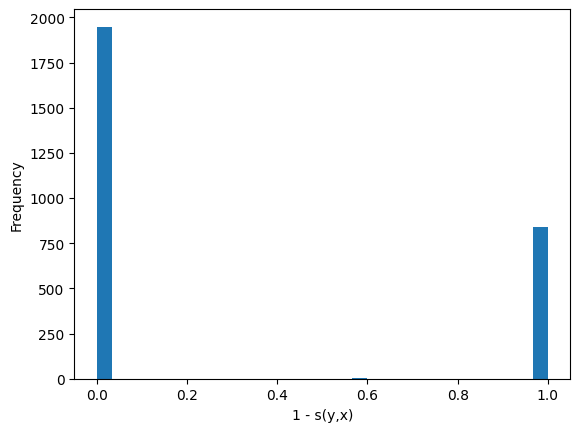

In [5]:
import matplotlib.pyplot as plt

# Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)
# Get for each instance the actual probability of ground truth
prob_for_true_class = predictions[np.arange(len(y_calib)),y_calib]
# Create a histogram
plt.hist(1 - prob_for_true_class, bins=30, range=(0, 1))
# Add a title and labels
plt.xlabel("1 - s(y,x)")
plt.ylabel("Frequency")
plt.show()

In [6]:
prediction_sets = (1 - model.predict_proba(X_new) <= qhat)

In [7]:
for i in range(10):
    print(prediction_sets[i])

[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]


In [8]:
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_mean_width_score

y_set = np.squeeze(prediction_sets)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print('Avg. set size: {:.2f}'.format(setsize))

Coverage: 100.00%
Avg. set size: 2.00
